##Importación del Dataset

In [3]:
#Lectura del dataset
data_link = "https://drive.google.com/uc?id=1-4nWuRu_X8q9PA3DzSSW9CdfP_4etFK0&export=download"

In [4]:
#El método "read_csv" nos permite leer un excel
dataset = pd.read_csv(data_link)

##Importación de Librerías

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from pprint import pprint

pd.set_option("display.max_columns", 50)

%matplotlib inline

##Revisión del Dataset

In [6]:
#Tamaño del dataset (registros, variables). En la nomenclatura de pandas es (axis 0, axis 1)
dataset.shape

(12684, 26)

In [7]:
#Vemos los primeros registros del dataset
dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


##Pre-procesamiento del Dataset


In [8]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()
  
  #Eliminamos la variable "toCoupon_GEQ5min"
  preprocessed_dataset.drop("toCoupon_GEQ5min", axis=1, inplace=True)

  #Eliminamos la variable "direction_same"
  preprocessed_dataset.drop("direction_same", axis=1, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7
  null_percentages = preprocessed_dataset.isna().sum() / len(preprocessed_dataset)
  criteria = null_percentages > threshold
  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
      #Determinamos si la variable es numérica o no
      if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
        numeric_columns.append(column)
      else:
        #Modificamos el tipo de dato de la variable mediante "astype"
        preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

        #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
        if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
          raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()
        
        #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
        for index, category in enumerate(preprocessed_dataset[column].cat.categories):
          dictionary_of_columns_with_index_to_categorical[column][index] = category
          dictionary_of_columns_with_categorical_to_index[column][category] = index
        
        categorical_columns.append(column)
    
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Generamos una nueva lista de variables categóricas y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
      
  return preprocessed_dataset

In [9]:
#Preprocesamos los datos
preprocessed_dataset = preprocess_dataset(dataset)

In [10]:
#Guardamos nuestro dataset pre-procesado en formato pickle
preprocessed_dataset.to_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [11]:
preprocessed_dataset.shape

(12610, 23)

In [12]:
preprocessed_dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_opp,Y
0,1,0,2,55,2,4,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,1
1,1,1,2,80,0,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,0
2,1,1,2,80,0,1,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,1
3,1,1,2,80,2,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0
4,1,1,2,80,2,2,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0


In [13]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [14]:
numeric_columns

['temperature',
 'has_children',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_opp',
 'Y']

In [15]:
categorical_columns

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [16]:
#Vemos los índices que tienen los valores (categorías) de la columna (variable).
dictionary_of_columns_with_index_to_categorical

{'Bar': {0: '1~3', 1: '4~8', 2: 'gt8', 3: 'less1', 4: 'never'},
 'CarryAway': {0: '1~3', 1: '4~8', 2: 'gt8', 3: 'less1', 4: 'never'},
 'CoffeeHouse': {0: '1~3', 1: '4~8', 2: 'gt8', 3: 'less1', 4: 'never'},
 'Restaurant20To50': {0: '1~3', 1: '4~8', 2: 'gt8', 3: 'less1', 4: 'never'},
 'RestaurantLessThan20': {0: '1~3',
  1: '4~8',
  2: 'gt8',
  3: 'less1',
  4: 'never'},
 'age': {0: '21',
  1: '26',
  2: '31',
  3: '36',
  4: '41',
  5: '46',
  6: '50plus',
  7: 'below21'},
 'coupon': {0: 'Bar',
  1: 'Carry out & Take away',
  2: 'Coffee House',
  3: 'Restaurant(20-50)',
  4: 'Restaurant(<20)'},
 'destination': {0: 'Home', 1: 'No Urgent Place', 2: 'Work'},
 'education': {0: 'Associates degree',
  1: 'Bachelors degree',
  2: 'Graduate degree (Masters or Doctorate)',
  3: 'High School Graduate',
  4: 'Some High School',
  5: 'Some college - no degree'},
 'expiration': {0: '1d', 1: '2h'},
 'gender': {0: 'Female', 1: 'Male'},
 'income': {0: '$100000 or More',
  1: '$12500 - $24999',
  2: '$2

In [17]:
preprocessed_dataset.dtypes

destination               int64
passanger                 int64
weather                   int64
temperature               int64
time                      int64
coupon                    int64
expiration                int64
gender                    int64
age                       int64
maritalStatus             int64
has_children              int64
education                 int64
occupation                int64
income                    int64
Bar                     float64
CoffeeHouse             float64
CarryAway               float64
RestaurantLessThan20    float64
Restaurant20To50        float64
toCoupon_GEQ15min         int64
toCoupon_GEQ25min         int64
direction_opp             int64
Y                         int64
dtype: object

## Visualizamos la data

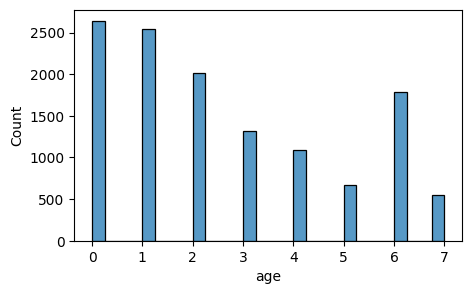

In [18]:
width = 5
height = 3

plt.style.use("default")

plt.figure(figsize=(width, height))

#sns.distplot(preprocessed_dataset['age'], )
sns.histplot(preprocessed_dataset['age'], )
plt.show()

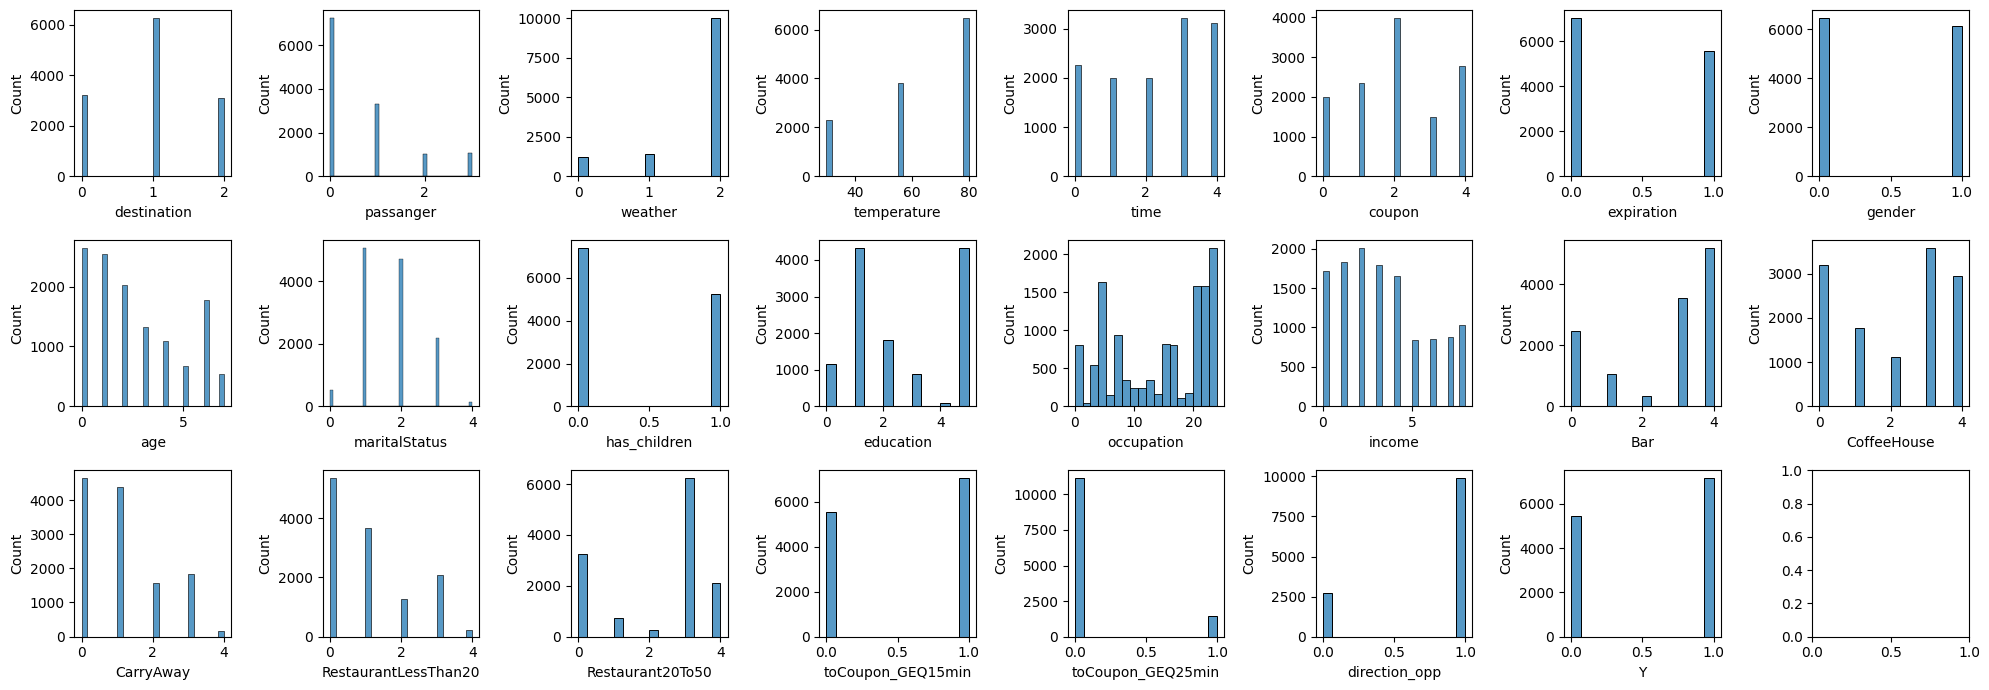

In [19]:
width = 20
height = 7

plt.style.use("default")

figure, axes = plt.subplots(nrows=3, ncols=8, figsize=(width, height))

for column, axe in zip(preprocessed_dataset, axes.flatten()):
    #sns.distplot(preprocessed_dataset[column], ax=axe)
    sns.histplot(preprocessed_dataset[column], ax=axe)
    
plt.tight_layout()

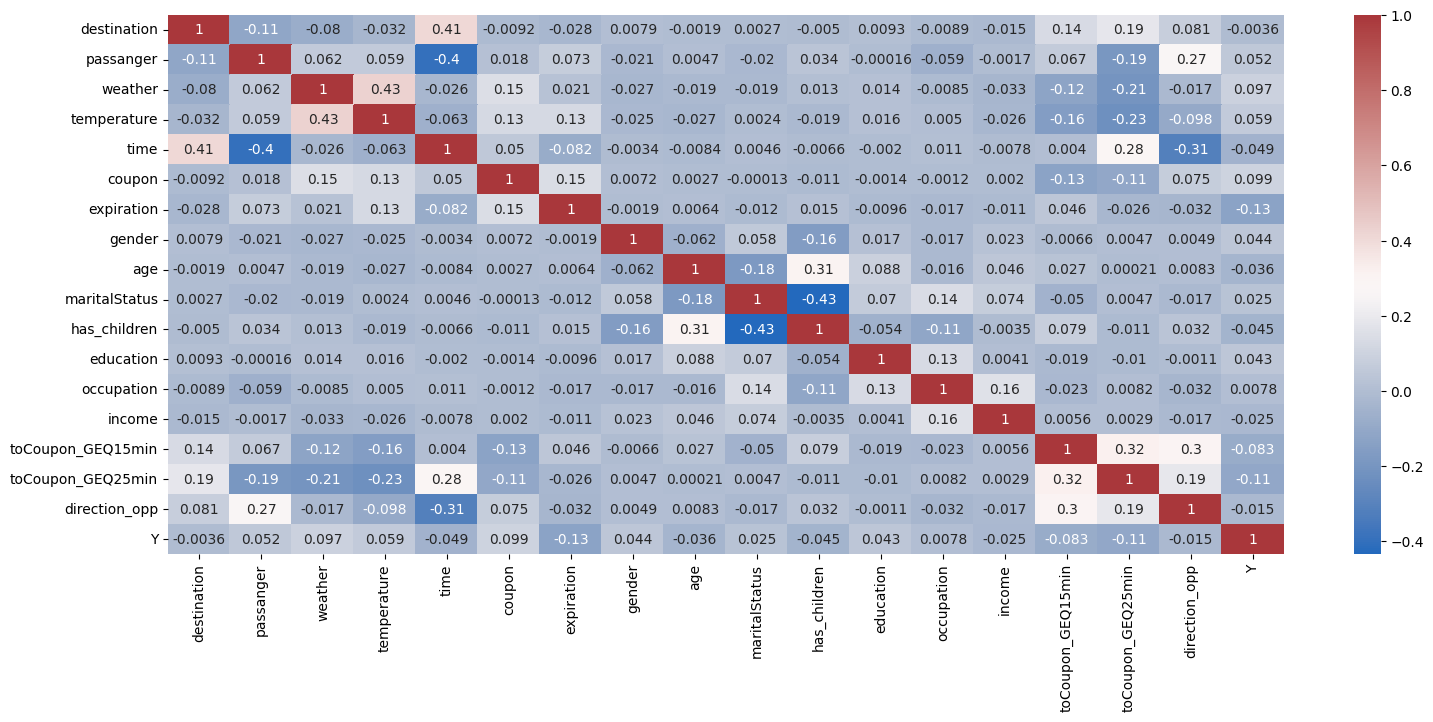

In [20]:
plt.figure(figsize=[18,7])
cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(preprocessed_dataset.select_dtypes('int64', 'float64').corr(), cmap=cmap, annot=True)
plt.show()

## Dividimos la data

In [21]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = preprocessed_dataset.drop("Y", axis=1)

y = preprocessed_dataset["Y"]

In [22]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [23]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (10088, 22)
Test shape: (2522, 22)


##Entrenamiento del modelo

In [42]:
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [43]:
# Training classifiers
estimators = [
     ('Random Forest', RandomForestClassifier(bootstrap=False,criterion='gini',max_depth=200,
           min_samples_leaf=1,min_samples_split=5,n_estimators=2152)),
     ('árbol de decisión', DecisionTreeClassifier(max_depth=50)),
     ('k-NN', make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=50) )),
     ('SVM de kernel gaussiano', make_pipeline(StandardScaler(),
                                               SVC(C=3.1623, gamma=0.1000, kernel='rbf', probability=True) ))
]

ensamble = StackingClassifier(estimators=estimators, 
                              final_estimator=LogisticRegression(penalty='l2') )
ensamble.fit(x_train, y_train)

StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=200,
                                                       min_samples_split=5,
                                                       n_estimators=2152)),
                               ('árbol de decisión',
                                DecisionTreeClassifier(max_depth=50)),
                               ('k-NN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=50))])),
                               ('SVM de kernel gaussiano',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),


In [44]:
for (name, estimator) in ensamble.named_estimators_.items():
  print(f'Exactitud de {name: <25}: Entrenamiento {estimator.score(x_train, y_train):.03f} || Pruebas {estimator.score(x_test, y_test):.03f}',  )

print(f'Exactitud de {"ensamble": <25}: Entrenamiento {ensamble.score(x_train, y_train):.03f} || Pruebas {ensamble.score(x_test, y_test):.03f}' )

Exactitud de Random Forest            : Entrenamiento 0.998 || Pruebas 0.757
Exactitud de árbol de decisión        : Entrenamiento 0.999 || Pruebas 0.686
Exactitud de k-NN                     : Entrenamiento 0.695 || Pruebas 0.667
Exactitud de SVM de kernel gaussiano  : Entrenamiento 0.944 || Pruebas 0.692
Exactitud de ensamble                 : Entrenamiento 0.999 || Pruebas 0.761


AUC = 0.820173120909852


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


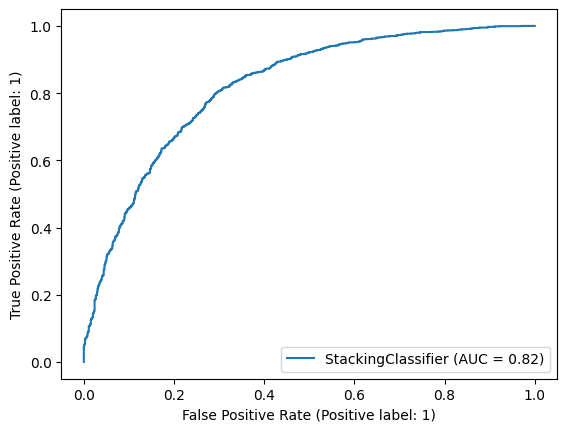

In [45]:
from sklearn import metrics

y_pred_val = ensamble.predict_proba(x_test)[:,1]
auc_roc = metrics.roc_auc_score(y_test, y_pred_val)
print('AUC =', auc_roc)

metrics.plot_roc_curve(ensamble, x_test, y_test)
plt.show()     